<a href="https://colab.research.google.com/github/wjdsheep15/AIStudy/blob/main/GAN_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
EPOCHS = 10
BATCH_SIZE = 100

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [ ]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Tanh()
)

In [ ]:
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    nn.Sigmoid()
)

In [ ]:
D = D.to(DEVICE)
G = G.to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

In [ ]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
  for i, (images, _) in enumerate(train_loader):
    images = images.reshape(BATCH_SIZE, -1).to(DEVICE)

    # 진짜이미지(1)와 가짜이미지(0)의 labeling 작업

    real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

    #진짜 이미지를 discriminator의 입력으로 제공
    outputs = D(images)

    #discriminator의 진짜 이미지를 진짜로 인식하는 real_loss 구함
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # random으로 가짜 이미지 입력값 생성
    z = torch.randn(BATCH_SIZE, 64).to(DEVICE)

    # 생성자(Generator) G로 가짜 이미지 생성
    fake_images = G(z)

    #판별자(Discriminator) D의 가짜 이미지 인식 오차를 구함
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # 판별자(Discriminator) 오차
    d_loss = d_loss_real + d_loss_fake

    # 역전파 알고리즘으로 판별자(Discriminator) 학습
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #생성자(Generator) 오차를 구함
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = criterion(outputs, real_labels)

    # 역전파 알고리즘으로 생성자(Generator) 학습
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

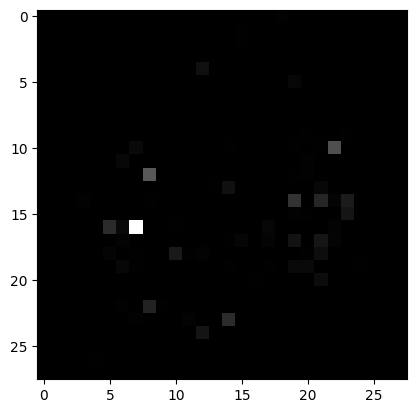

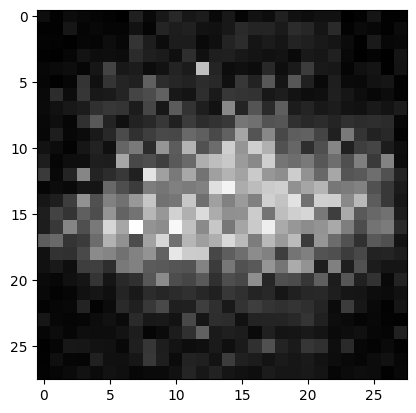

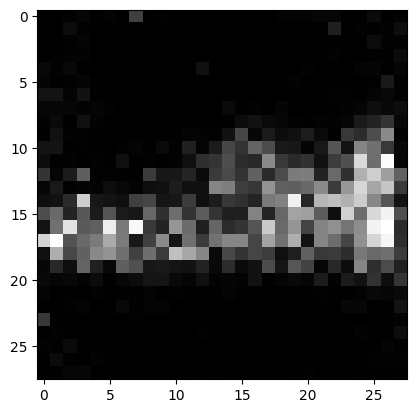

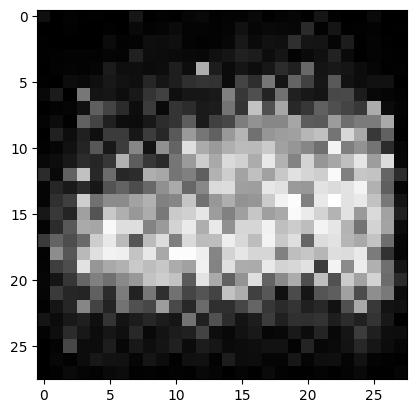

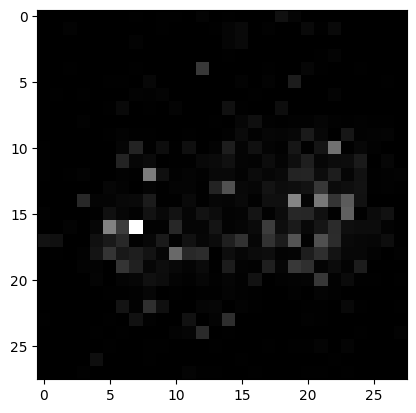

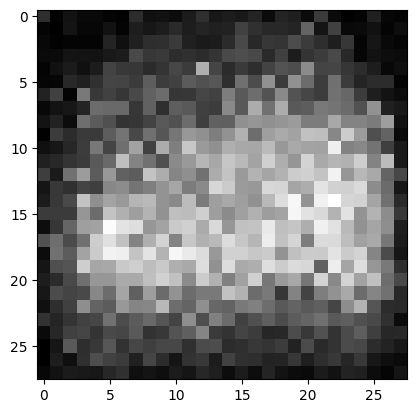

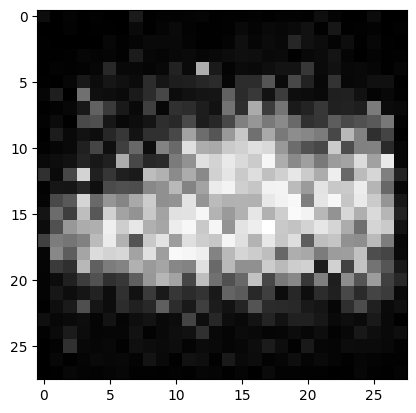

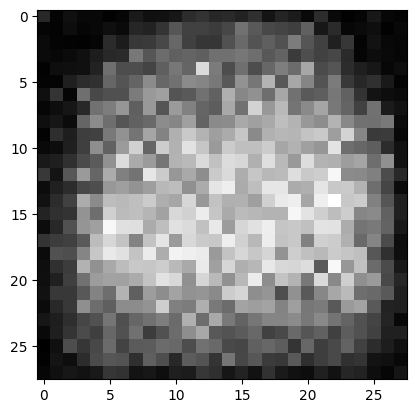

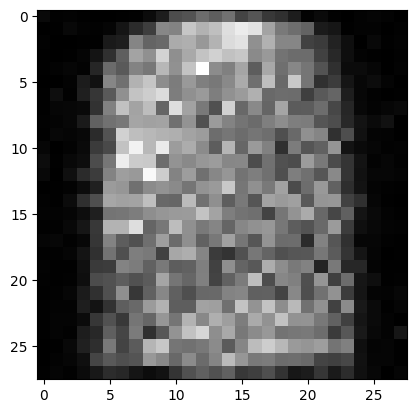

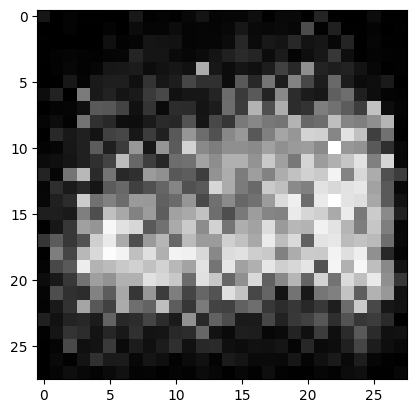

In [ ]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
  plt.imshow(fake_images_img, cmap = 'gray')
  plt.show()